In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

2024-08-01 09:58:34.026991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 09:58:34.027097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 09:58:34.178509: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/ferplus/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/ferplus/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 66379 images belonging to 8 classes.
Found 8341 images belonging to 8 classes.


In [4]:
# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='elu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
# Freeze the base model layers
# for layer in base_model.layers:
#     layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# Save model architecture to PNG
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [7]:
# Training
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722506431.779693      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722506431.882278      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2075/2075 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.6712 - loss: 0.9252

W0000 00:00:1722507597.825930      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2075/2075 ━━━━━━━━━━━━━━━━━━━━ 1315s 599ms/step - accuracy: 0.6712 - loss: 0.9251 - val_accuracy: 0.7131 - val_loss: 0.9441
Epoch 2/10


W0000 00:00:1722507674.704945      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2075/2075 ━━━━━━━━━━━━━━━━━━━━ 913s 439ms/step - accuracy: 0.8706 - loss: 0.3613 - val_accuracy: 0.6797 - val_loss: 1.1893
Epoch 3/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 911s 437ms/step - accuracy: 0.8993 - loss: 0.2798 - val_accuracy: 0.7159 - val_loss: 1.1725
Epoch 4/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 926s 444ms/step - accuracy: 0.9155 - loss: 0.2333 - val_accuracy: 0.6849 - val_loss: 1.1576
Epoch 5/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 987s 447ms/step - accuracy: 0.9259 - loss: 0.2017 - val_accuracy: 0.6898 - val_loss: 1.2910
Epoch 6/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 936s 450ms/step - accuracy: 0.9325 - loss: 0.1838 - val_accuracy: 0.7245 - val_loss: 1.0111
Epoch 7/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 936s 449ms/step - accuracy: 0.9423 - loss: 0.1582 - val_accuracy: 0.6879 - val_loss: 1.3918
Epoch 8/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 942s 453ms/step - accuracy: 0.9493 - loss: 0.1391 - val_accuracy: 0.7305 - val_loss: 1.1517
Epoch 9/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 941s 452ms/step - accuracy: 0.9

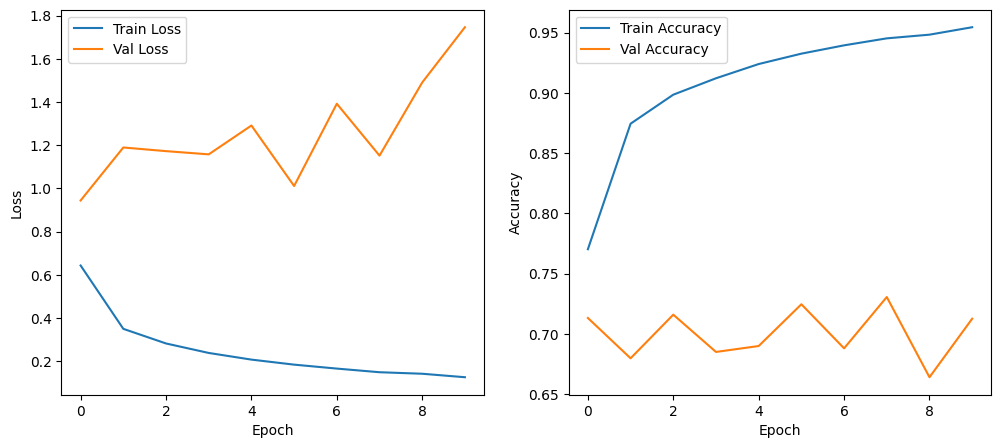

In [8]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()